# Методы глубокого обучения в задаче предсказания заболевания

## Введение

Сердечно-сосудистые заболевания являются ведущей причиной смертности во всем мире, которая в странах с высоким уровнем дохода уступает только онкологическим заболеваниям. Поэтому своевременное обнаружение патологий в работе сердца считается одной из главных задач современной медицины. Современные системы поддержки принятия решений, основанные на алгоритмах автоматической интерпретации ЭКГ, обещают значительную помощь медицинскому персоналу. 

В настоящее время существует множество решений машинного обучения, которые можно использовать для анализа и классификации данных ЭКГ. Однако основным недостатком этих результатов машинного обучения является использование эвристических, созданных вручную или спроектированных функций с неглубокой архитектурой изучения функций. Проблема заключается в возможности не найти наиболее подходящие признаки, которые обеспечат высокую точность классификации в этой задаче ЭКГ. Одно из предлагаемых решений - использовать архитектуры глубокого обучения, в которых первые слои сверточных нейронов ведут себя как экстракторы признаков, а в конечном итоге некоторые полностью связанные слои используются для принятия окончательного решения о классах ЭКГ.

В данной работе используется самый большой на сегодняшний день бесплатный клинический набор данных ЭКГ PTB-XL [1].

## Постановка учебно-практической задачи

В данной работе мы будем решать задачу классификации. Задача классификации — это задача отнесения объекта к одному из заранее определенных классов на основании его формализованных признаков. В этой работе будет рассмотрено 5 диагностических суперклассов плюс еще один, для тех пациентов, у которых он не был поставлен:

* NORM — нормальное экг 
* MI — Инфаркт миокарда
* STTC — изменение ST / T
* CD — нарушение проводимости
* HYP — гипертрофия
* UNKNOWN — диагностический суперкласс не определен

Перед применением различых методов обучения нам будет необходимо предварительно обработать данные. Нужно обработать пропущенные значения, отобрать необходимые нам признаки, а так же дополнительно обработать категориальные признаки.

### Предобработка данных

In [1]:
import tensorflow as tf
import sklearn
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np
import wfdb
import ast
import seaborn as sns 

#### Чтение данных:

С помощью функции load_raw_data и модуля wfdb загрузим данные сигналов с 12 датчиков в виде numpy.array и сохраним в X. В Y будем хранить набор данных PTB-XL.

In [2]:
def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(path + f) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(path + f) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data

path = './/ecg/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/'
sampling_rate=100

Y = pd.read_csv(path + 'ptbxl_database.csv', index_col = 'ecg_id')
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x)) 

X = load_raw_data(Y, sampling_rate, path)

agg_df = pd.read_csv(path + 'scp_statements.csv', index_col = 0)  
agg_df = agg_df[agg_df.diagnostic == 1]

def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

#### Отбор признаков:

Добавим столбец diagnostic_superclass:

In [3]:
z = Y.scp_codes.apply(aggregate_diagnostic)
z

ecg_id
1        [NORM]
2        [NORM]
3        [NORM]
4        [NORM]
5        [NORM]
          ...  
21833    [STTC]
21834    [NORM]
21835    [STTC]
21836    [NORM]
21837    [NORM]
Name: scp_codes, Length: 21837, dtype: object

Так как не для всех пациентов был обределен диагностический суперкласс, заполним пропуски значением UNKNOWN.

In [4]:
diagnostic_superclass = []
for i in range(1, 21838):
    if z[i] != []:
        diagnostic_superclass.append(z[i][0])
    else:
        diagnostic_superclass.append('UNKNOWN')

In [5]:
diagnostic_superclass = pd.Series(diagnostic_superclass , name = 'diagnostic_superclass')
diagnostic_superclass.index = range(1,21838)

Добавим столбец diagnostic_superclass к набору данных PTB-XL.

In [6]:
Y = pd.concat((Y, diagnostic_superclass), axis=1)
Y.head()

,patient_id,age,sex,height,weight,nurse,site,device,recording_date,report,...,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr,diagnostic_superclass
1,15709.0,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,sinusrhythmus periphere niederspannung,...,NaN,", I-V1,",NaN,NaN,NaN,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr,NORM
2,13243.0,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,sinusbradykardie sonst normales ekg,...,NaN,NaN,NaN,NaN,NaN,NaN,2,records100/00000/00002_lr,records500/00000/00002_hr,NORM
3,20372.0,37.0,1,NaN,69.0,2.0,0.0,CS-12 E,1984-11-15 12:49:10,sinusrhythmus normales ekg,...,NaN,NaN,NaN,NaN,NaN,NaN,5,records100/00000/00003_lr,records500/00000/00003_hr,NORM
4,17014.0,24.0,0,NaN,82.0,2.0,0.0,CS-12 E,1984-11-15 13:44:57,sinusrhythmus normales ekg,...,", II,III,AVF",NaN,NaN,NaN,NaN,NaN,3,records100/00000/00004_lr,records500/00000/00004_hr,NORM
5,17448.0,19.0,1,NaN,70.0,2.0,0.0,CS-12 E,1984-11-17 10:43:15,sinusrhythmus normales ekg,...,", III,AVR,AVF",NaN,NaN,NaN,NaN,NaN,4,records100/00000/00005_lr,records500/00000/00005_hr,NORM


Для задачи предсказания типа ритма нам понадобятся только столбцы 'age', 'sex', 'height', 'weight', 'diagnostic_superclass' и данные 2-го датчика для каждого пациента.

In [7]:
Y = Y[['age', 'sex', 'height', 'weight', 'diagnostic_superclass']]
Y.head()

,age,sex,height,weight,diagnostic_superclass
1,56.0,1,NaN,63.0,NORM
2,19.0,0,NaN,70.0,NORM
3,37.0,1,NaN,69.0,NORM
4,24.0,0,NaN,82.0,NORM
5,19.0,1,NaN,70.0,NORM


In [8]:
Y['diagnostic_superclass'].unique()

array(['NORM', 'MI', 'UNKNOWN', 'STTC', 'HYP', 'CD'], dtype=object)

In [9]:
X.shape

(21837, 1000, 12)

оставим в X только данные сигнала, записанные на второй датчик:

In [10]:
X = X[:,:,1]
X

array([[-0.055, -0.051, -0.044, ...,  0.   ,  0.004, -0.031],
       [ 0.138,  0.116,  0.092, ...,  0.398,  0.057, -0.056],
       [-0.079, -0.07 , -0.057, ..., -0.226, -0.266, -0.288],
       ...,
       [ 0.024,  0.066, -0.006, ..., -0.062,  0.026,  0.53 ],
       [-0.057, -0.029,  0.045, ...,  0.07 ,  0.082,  0.051],
       [-0.025, -0.029, -0.042, ...,  0.012,  0.022, -0.007]])

In [11]:
X = pd.DataFrame(X)
X.index = range(1,21838)

Добавим к набору данных PTB-XL сигналы, записанные в X.

In [12]:
Y = pd.concat((Y, X), axis=1)
Y.head()

,age,sex,height,weight,diagnostic_superclass,0,1,2,3,4,...,990,991,992,993,994,995,996,997,998,999
1,56.0,1,NaN,63.0,NORM,-0.055,-0.051,-0.044,-0.038,-0.031,...,0.189,0.152,0.093,0.070,0.023,0.028,0.021,0.000,0.004,-0.031
2,19.0,0,NaN,70.0,NORM,0.138,0.116,0.092,0.089,0.083,...,0.051,-0.019,0.029,0.034,0.792,1.320,0.773,0.398,0.057,-0.056
3,37.0,1,NaN,69.0,NORM,-0.079,-0.070,-0.057,-0.120,-0.061,...,-0.186,-0.202,-0.208,-0.228,-0.251,-0.240,-0.234,-0.226,-0.266,-0.288
4,24.0,0,NaN,82.0,NORM,-0.138,-0.156,-0.153,-0.161,-0.193,...,-0.478,-1.141,-1.284,-1.161,-0.981,-0.965,-0.928,-0.915,-0.910,-0.899
5,19.0,1,NaN,70.0,NORM,-0.574,-0.575,-0.584,-0.592,-0.588,...,0.241,0.249,0.238,0.231,0.218,0.180,0.164,0.160,0.157,0.148


#### Обработка пропущенных значений:

In [13]:
Y[['age','sex','height','weight','diagnostic_superclass']].isna().sum()

age                         89
sex                          0
height                   14854
weight                   12408
diagnostic_superclass        0
dtype: int64

Заменим все пропущенные значения в столцах age, height, weight на -1.

In [14]:
Y['age'].fillna(-1, inplace=True)
Y['height'].fillna(-1, inplace=True)
Y['weight'].fillna(-1, inplace=True)

In [15]:
Y[['age','sex','height','weight','diagnostic_superclass']].isna().sum()

age                      0
sex                      0
height                   0
weight                   0
diagnostic_superclass    0
dtype: int64

#### Обработка категориальных признаков:

In [16]:
Y['diagnostic_superclass'].dtype

dtype('O')

In [17]:
Y['diagnostic_superclass'] = Y['diagnostic_superclass'].astype('category')

### Визуализация:

In [18]:
Y.head()

,age,sex,height,weight,diagnostic_superclass,0,1,2,3,4,...,990,991,992,993,994,995,996,997,998,999
1,56.0,1,-1.0,63.0,NORM,-0.055,-0.051,-0.044,-0.038,-0.031,...,0.189,0.152,0.093,0.070,0.023,0.028,0.021,0.000,0.004,-0.031
2,19.0,0,-1.0,70.0,NORM,0.138,0.116,0.092,0.089,0.083,...,0.051,-0.019,0.029,0.034,0.792,1.320,0.773,0.398,0.057,-0.056
3,37.0,1,-1.0,69.0,NORM,-0.079,-0.070,-0.057,-0.120,-0.061,...,-0.186,-0.202,-0.208,-0.228,-0.251,-0.240,-0.234,-0.226,-0.266,-0.288
4,24.0,0,-1.0,82.0,NORM,-0.138,-0.156,-0.153,-0.161,-0.193,...,-0.478,-1.141,-1.284,-1.161,-0.981,-0.965,-0.928,-0.915,-0.910,-0.899
5,19.0,1,-1.0,70.0,NORM,-0.574,-0.575,-0.584,-0.592,-0.588,...,0.241,0.249,0.238,0.231,0.218,0.180,0.164,0.160,0.157,0.148


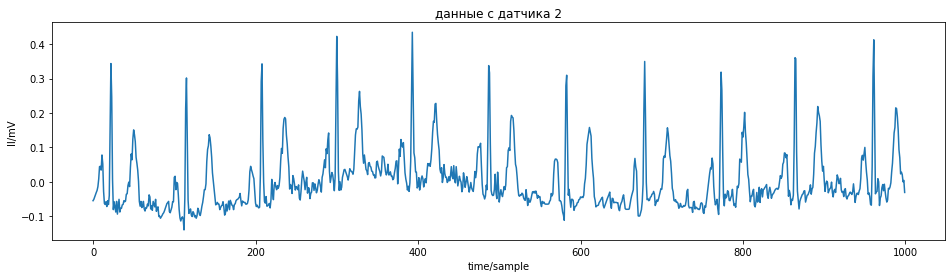

In [19]:
record = wfdb.rdrecord(path+'records100/00000/00001_lr', channels=[1])
wfdb.plot_wfdb(record=record, title='данные с датчика 2',figsize=(16,4))

In [20]:
print(Y['diagnostic_superclass'].value_counts())

NORM       9083
MI         4442
STTC       2828
HYP        2655
CD         2422
UNKNOWN     407
Name: diagnostic_superclass, dtype: int64


Распределение суперклассов:

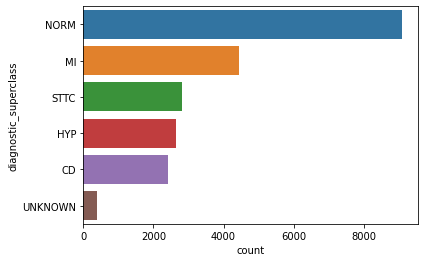

In [21]:
sns.countplot(y ='diagnostic_superclass', data=Y, order = Y['diagnostic_superclass'].value_counts().index)
pass

## Решение задачи классификации:

#### Разбиение на обучающую и тестовую выборки

In [22]:
y = Y['diagnostic_superclass']
X = Y.drop('diagnostic_superclass', axis = 1)

In [55]:
print("X:", X.shape)
print("y:", y.shape)

x: (21837, 1004)
y: (21837,)


In [58]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 21)

print("X_train :", X_train.shape)
print("y_train :", y_train.shape)
print("X_test :", X_test.shape)
print("y_test :", y_test.shape)

X_train : (16377, 1004)
y_train : (16377,)
X_test : (5460, 1004)
y_test : (5460,)


#### Обработка численных признаков

Чтобы нормализовать численные признаки, воспользуемся линейным преобразованием, приводящим все значения к нулевому среднему и единичному стандартному отклонению.

In [69]:
sc = sklearn.preprocessing.StandardScaler()
X_train = sc.fit_transform(X_train)
X_test  = sc.transform(X_test)

In [64]:
X_test = pd.DataFrame(X_test)
X_test.describe()

,0,1,2,3,4,5,6,7,8,9,...,994,995,996,997,998,999,1000,1001,1002,1003
count,5460.000000,5460.000000,5460.000000,5460.000000,5460.000000,5460.000000,5460.000000,5460.000000,5460.000000,5460.000000,...,5460.000000,5460.000000,5460.000000,5460.000000,5460.000000,5460.000000,5460.000000,5460.000000,5460.000000,5460.000000
mean,0.000444,0.009847,-0.016441,-0.016772,-0.011968,-0.011719,-0.013363,-0.016557,-0.015124,-0.011712,...,-0.007029,-0.005682,0.002119,-0.001831,0.006683,0.011642,0.013956,0.005570,0.006215,0.021801
std,0.998498,1.000483,0.993876,1.002049,0.967774,0.985583,0.995620,0.985602,0.958546,0.960629,...,1.028010,1.013971,1.040188,1.029633,1.023622,1.043930,1.053805,1.064385,1.074046,1.112139
min,-3.489325,-0.956317,-0.686608,-0.841299,-9.285061,-9.102220,-9.019816,-9.207227,-9.191609,-9.335043,...,-25.863401,-25.386842,-25.275323,-24.716597,-24.669282,-24.416852,-23.911798,-23.196525,-22.405818,-22.186732
25%,-0.552107,-0.956317,-0.686608,-0.841299,-0.398707,-0.404312,-0.397317,-0.405094,-0.404451,-0.404929,...,-0.380194,-0.385019,-0.386288,-0.380631,-0.385409,-0.387375,-0.387600,-0.390868,-0.389533,-0.395940
50%,0.081411,-0.956317,-0.686608,-0.841299,-0.100915,-0.098430,-0.098129,-0.092856,-0.092356,-0.095790,...,-0.091645,-0.101878,-0.099836,-0.097531,-0.088554,-0.080403,-0.067241,-0.065884,-0.062685,-0.056172
75%,0.714929,1.045678,1.336851,0.962817,0.284391,0.296257,0.304058,0.298680,0.303047,0.308084,...,0.282401,0.277423,0.298238,0.292400,0.303720,0.299031,0.289580,0.295210,0.299912,0.330504
max,1.981964,1.045678,1.833172,5.917405,9.068644,9.734202,9.284601,10.275422,8.469744,9.298032,...,18.578585,10.598688,10.605125,10.131480,9.601671,9.779600,11.249481,12.876752,13.200199,11.435085


#### Классификатор kNN

In [65]:
from sklearn.neighbors import KNeighborsClassifier

neighbors_array = np.array([1,5,7,21,51,121])
for i in range (6):
    knn = KNeighborsClassifier(n_neighbors = neighbors_array[i])
    knn.fit(X_train, y_train)
    print('neighbours =',neighbors_array[i],'train accuracy =',knn.score(X_train, y_train),'test accuracy =', knn.score(X_test, y_test))
    

neighbours = 1 train accuracy = 0.9998778775111437 test accuracy = 0.35018315018315016
neighbours = 5 train accuracy = 0.44061793979361297 test accuracy = 0.32857142857142857
neighbours = 7 train accuracy = 0.39488306771692006 test accuracy = 0.32161172161172163
neighbours = 21 train accuracy = 0.2963302192098675 test accuracy = 0.2794871794871795
neighbours = 51 train accuracy = 0.270806619038896 test accuracy = 0.2664835164835165
neighbours = 121 train accuracy = 0.26500580081822067 test accuracy = 0.26483516483516484


Так как kNN с одним соседом показывет лучшие результаты на тестовой выборке, построим матрицу ошибок для него:

In [102]:
knn = KNeighborsClassifier(n_neighbors = 1)
knn.fit(X_train, y_train)
print(confusion_matrix(y_test, knn.predict(X_test), labels=["NORM", "MI", "STTC", "CD", "HYP", "UNKNOWN"]))

[[ 834 1148  269   98   40    1]
 [ 224  922  117   95   14    2]
 [ 179  583  100   36   16    0]
 [ 108  256   63   32    7    2]
 [  79   96   25   11    6    0]
 [  13   37    9   13    7   18]]


834 раз - верно предсказал NORM; 922 раза - верно предсказал MI; 100 раз - верно предсказал STTC; 32 раза - верно предсказал CD; 6 раз- верно предсказал HYP и 18 раз - верно предсказал UNKNOWN.  

Метод ближайших соседей показал наибольшую точность для одного соседа $\approx$ 35%

#### Random Forest

In [73]:
from sklearn.ensemble import RandomForestClassifier

trees_array = np.array([10,25,50,100,200])
for i in range (5):
    rfc = RandomForestClassifier(n_estimators = trees_array[i])
    rfc.fit(X_train, y_train)
    print('trees =',trees_array[i],'train accuracy =',rfc.score(X_train, y_train),'test accuracy =', rfc.score(X_test, y_test))
     

trees = 10 train accuracy = 0.9896195884472125 test accuracy = 0.4716117216117216
trees = 25 train accuracy = 0.9998778775111437 test accuracy = 0.5084249084249084
trees = 50 train accuracy = 0.9998778775111437 test accuracy = 0.5225274725274726
trees = 100 train accuracy = 0.9998778775111437 test accuracy = 0.5274725274725275
trees = 200 train accuracy = 0.9998778775111437 test accuracy = 0.5232600732600733


In [87]:
rfc = RandomForestClassifier(n_estimators = 100)
rfc.fit(X_train, y_train)
print(confusion_matrix(y_test, rf.predict(X_test), labels=["NORM", "MI", "STTC", "CD", "HYP", "UNKNOWN"]))

[[2248  134    8    0    0    0]
 [ 736  610   24    4    0    0]
 [ 643  243   27    1    0    0]
 [ 276  177    9    6    0    0]
 [ 173   41    3    0    0    0]
 [  41   41    9    3    0    3]]


2248 раз - верно предсказал NORM; 610 раз - верно предсказал MI; 27 раз - верно предсказал STTC ; 6 раз - верно предсказал CD и 3 раза верно предсказал UNKNOWN

Классификатор никогда не предсказывает HYP

#### Сверточная нейронная сеть (CNN)

![title](cnn.jpg) 

<center>Иллюстрация архитектуры сверточной нейронной сети (CNN).</center>

Опираясь на статьи [2], [3], [4] попробуем построить и затем обучить сверточную нейронную сеть, на данный момент параметры этой сети не подбирались.

In [23]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
X = np.array(X)
y = np.array(y.tolist())
le = LabelEncoder()
yy = to_categorical(le.fit_transform(y))

In [24]:
from sklearn.model_selection import train_test_split 
x_train, x_test, y_train, y_test = train_test_split(X, yy, test_size=0.2, random_state = 21)

In [25]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(17469, 1004)
(4368, 1004)
(17469, 6)
(4368, 6)


In [216]:
def CNN(x_train,y_train,x_test,y_test):
    im_shape=(x_train.shape[1],1)
    inputs_cnn=Input(shape=(im_shape))
    
    conv1_1=Convolution1D(64, (6), activation='relu', input_shape=im_shape)(inputs_cnn)
    conv1_1=BatchNormalization()(conv1_1)
    pool1=MaxPool1D(pool_size=(3), strides=(2), padding="same")(conv1_1)
    
    conv2_1=Convolution1D(64, (3), activation='relu', input_shape=im_shape)(pool1)
    conv2_1=BatchNormalization()(conv2_1)
    pool2=MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv2_1)
    
    conv3_1=Convolution1D(64, (3), activation='relu', input_shape=im_shape)(pool2)
    conv3_1=BatchNormalization()(conv3_1)
    pool3=MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv3_1)
    
    flatten=Flatten()(pool3)
    dense_end1 = Dense(64, activation='relu')(flatten)
    dense_end2 = Dense(32, activation='relu')(dense_end1)
    main_output = Dense(6, activation='softmax', name='main_output')(dense_end2)
    
    model = Model(inputs = inputs_cnn, outputs = main_output)
    model.compile(optimizer='adam', loss='categorical_crossentropy',metrics = ['accuracy'])
    
    history=model.fit(x_train, y_train, epochs=12, batch_size=32,validation_data=(x_test,y_test))
    return(model,history)

In [217]:
from keras.layers import Dense, Convolution1D, MaxPool1D, Flatten, Dropout
from keras.layers import Input
from keras.models import Model
from keras.layers.normalization import BatchNormalization
import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint

model, history = CNN(x_train,y_train,x_test,y_test)

Epoch 1/12
546/546 [==============================] - 117s 214ms/step - loss: 1.1734 - accuracy: 0.5747 - val_loss: 1.3812 - val_accuracy: 0.5167
Epoch 2/12
546/546 [==============================] - 112s 205ms/step - loss: 0.9909 - accuracy: 0.6398 - val_loss: 1.0520 - val_accuracy: 0.6099
Epoch 3/12
546/546 [==============================] - 115s 210ms/step - loss: 0.9098 - accuracy: 0.6685 - val_loss: 1.0240 - val_accuracy: 0.6298
Epoch 4/12
546/546 [==============================] - 159s 290ms/step - loss: 0.8296 - accuracy: 0.6974 - val_loss: 1.0258 - val_accuracy: 0.6413
Epoch 5/12
546/546 [==============================] - 145s 266ms/step - loss: 0.7305 - accuracy: 0.7323 - val_loss: 1.1357 - val_accuracy: 0.5966
Epoch 6/12
546/546 [==============================] - 145s 265ms/step - loss: 0.6099 - accuracy: 0.7753 - val_loss: 1.2143 - val_accuracy: 0.5996
Epoch 7/12
546/546 [==============================] - 147s 269ms/step - loss: 0.4818 - accuracy: 0.8228 - val_loss: 1.3687 -

In [222]:
def evaluate_model(history,X_test,y_test,model):
    scores = model.evaluate((X_test),y_test, verbose=0)
    print(history)
    fig1, ax_acc = plt.subplots()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Model - Accuracy')
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()

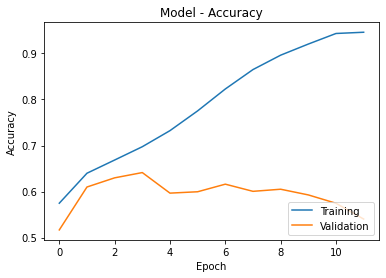

In [225]:
evaluate_model(history,x_test,y_test,model)

При использовании CNN на тестовой выборке была достигнута точность 64%

## Заключение

* методы обучения kNN и Random Forest показывают малую точность классификации для данного набора данных, это может быть связано с тем, что эти методы не могут найти наиболее подходящие признаки, которые обеспечат высокую точность классификации в этой задаче ЭКГ.
* kNN показал точность $\approx$ 35% при использовании 1 ближайшего соседа, при этом он приемужественно классифицировал все классы как MI.
* Random Forest показал точность $\approx$ 52%, приемужественно классифицировал все классы как NORM и ни разу не классифицировал HYP.
* была обнаружена несбаланисрованность классов, с которой нужно будет побороться.
* при увеличении количества эпох CNN наблюдается переобучение, при epoch = 12 точность на тренировочной выборке составляет 94.6%, а на тестововй 54%.
* CNN показал самую высокую точность $\approx$ 64% среди всех примененных на данный момент методов на тестовой выборке.

##### На данный момент можно сделать следующий вывод:
* для данной задачи необходимо использовать методы глубокого обучения, чтобы находить абстрактные признаки, которые повысят точность классификации. 

## Список литературы

1. Wagner P. et al. PTB-XL, a large publicly available electrocardiography dataset //Scientific Data. – 2020. – Т. 7. – №. 1. – С. 1-15.
2. Ebrahimi Z. et al. A review on deep learning methods for ECG arrhythmia classification //Expert Systems with Applications: X. – 2020. – С. 100033.
3. Pyakillya B., Kazachenko N., Mikhailovsky N. Deep learning for ECG classification //Journal of physics: conference series. – 2017. – Т. 913. – №. 1.
4. Victor Moskalenko, Nikolai Zolotykh, and Grigory Osipov. Deep learning for ecg segmentation. In International Conference on Neuroinformatics, pages 246–254. Springer, 2019.